## Day 2

For some reason running **CarveMe** in jupyter is causing it to hang, so the carve me was called from commandline as

python C:\Users\daven\AppData\Local\Programs\Python\Python36\Scripts\carve --refseq GCF_001548235.1 -o Rothia_mucilaginosa.xml -v<br>
python C:\Users\daven\AppData\Local\Programs\Python\Python36\Scripts\carve --refseq GCF_001069775.1 -o Streptococcus_cristatus.xml -v<br>
python C:\Users\daven\AppData\Local\Programs\Python\Python36\Scripts\carve --refseq GCF_001069855.1 -o Streptococcus_salivarius.xml -v<br>
python C:\Users\daven\AppData\Local\Programs\Python\Python36\Scripts\carve --refseq GCF_003584215.1 -o Veillonella_parvula.xml -v


Now let's load the model and run a simple simulation to see if everything is working.

In [23]:
from framed import load_cbmodel, pFBA
from framed.experimental import medium
from framed import Environment

for f in ['Rothia_mucilaginosa','Streptococcus_cristatus','Streptococcus_salivarius','Veillonella_parvula']:
    model = load_cbmodel(r'C:\Users\daven\Documents\bioinformatika\metabolic modeling\project\\'+f+'.xml', flavor='cobra')
    (m,solution) = medium.minimal_medium(model,min_mass_weight=True)
    print(m)
    Environment.from_compounds(m,exchange_format="'{}'").apply(model)
    solution = pFBA(model)
    print(solution)
    print( 'growth rate', solution.values[m_model.biomass_reaction] )

c:\users\daven\appdata\local\programs\python\python36\lib\site-packages\framed\experimental\medium.py:48: UserWarning: Coupounds with multiple formulas (using first): M_pi_e,M_nh4_e,M_meoh_e,M_fol_e,M_gua_e,M_h2co3_e,M_h2s_e,M_pheme_e,M_taur_e,M_nmn_e,M_quin_e,M_so4_e,M_urea_e,M_so3_e,M_tsul_e
  warn(message)


{'R_EX_so4_e', 'R_EX_pi_e', 'R_EX_o2_e', 'R_EX_ca2_e', 'R_EX_zn2_e', 'R_EX_his__L_e', 'R_EX_cl_e', 'R_EX_mn2_e', 'R_EX_cu2_e', 'R_EX_mg2_e', 'R_EX_nmn_e', 'R_EX_asn__L_e', 'R_EX_h_e', 'R_EX_k_e', 'R_EX_fe3_e', 'R_EX_cobalt2_e', 'R_EX_ser__L_e', 'R_EX_ala_B_e', 'R_EX_arg__L_e'}
Objective: 729.7105314535875
Status: Optimal

growth rate 0.45264486733598147


c:\users\daven\appdata\local\programs\python\python36\lib\site-packages\framed\experimental\medium.py:48: UserWarning: Coupounds with multiple formulas (using first): M_pi_e,M_ribflv_e,M_nh4_e,M_meoh_e,M_citr__L_e,M_for_e,M_gua_e,M_h2s_e,M_pheme_e,M_nmn_e,M_pnto__R_e,M_so4_e,M_tsul_e
  warn(message)


{'R_EX_4hbald_e', 'R_EX_pnto__R_e', 'R_EX_so4_e', 'R_EX_ribflv_e', 'R_EX_pi_e', 'R_EX_o2_e', 'R_EX_ca2_e', 'R_EX_zn2_e', 'R_EX_his__L_e', 'R_EX_mn2_e', 'R_EX_cu2_e', 'R_EX_mg2_e', 'R_EX_glc__D_e', 'R_EX_cl_e', 'R_EX_nmn_e', 'R_EX_k_e', 'R_EX_fe3_e', 'R_EX_cobalt2_e', 'R_EX_arg__L_e'}
Objective: 326.73060383325094
Status: Optimal

growth rate 0.24569377743212495


c:\users\daven\appdata\local\programs\python\python36\lib\site-packages\framed\experimental\medium.py:48: UserWarning: Coupounds with multiple formulas (using first): M_hco3_e,M_pi_e,M_ribflv_e,M_nh4_e,M_alltn_e,M_meoh_e,M_for_e,M_cyst__L_e,M_fol_e,M_gthrd_e,M_gthox_e,M_gua_e,M_h2s_e,M_pheme_e,M_nmn_e,M_pnto__R_e,M_so4_e,M_urea_e,M_tsul_e
  warn(message)


{'R_EX_pnto__R_e', 'R_EX_chols_e', 'R_EX_thm_e', 'R_EX_ribflv_e', 'R_EX_bzal_e', 'R_EX_ca2_e', 'R_EX_zn2_e', 'R_EX_o2_e', 'R_EX_fe2_e', 'R_EX_mn2_e', 'R_EX_cu2_e', 'R_EX_gam_e', 'R_EX_mg2_e', 'R_EX_nmn_e', 'R_EX_cl_e', 'R_EX_k_e', 'R_EX_fe3_e', 'R_EX_cobalt2_e'}
Objective: 330.4430583680977
Status: Optimal

growth rate 0.2555673184267556


c:\users\daven\appdata\local\programs\python\python36\lib\site-packages\framed\experimental\medium.py:48: UserWarning: Coupounds with multiple formulas (using first): M_pi_e,M_nh4_e,M_meoh_e,M_for_e,M_gthrd_e,M_gthox_e,M_gua_e,M_h2s_e,M_pheme_e,M_taur_e,M_nmn_e,M_rnam_e,M_so4_e,M_urea_e,M_so3_e,M_tsul_e
  warn(message)


{'R_EX_akg_e', 'R_EX_pi_e', 'R_EX_o2_e', 'R_EX_ca2_e', 'R_EX_zn2_e', 'R_EX_fe2_e', 'R_EX_gly_e', 'R_EX_cl_e', 'R_EX_mn2_e', 'R_EX_cu2_e', 'R_EX_mg2_e', 'R_EX_asn__L_e', 'R_EX_so4_e', 'R_EX_k_e', 'R_EX_cobalt2_e'}
Objective: 256.4500424515802
Status: Optimal

growth rate 0.19458407409351103


Great! Now things are starting to make sense.

In [56]:
!python C:\Users\daven\AppData\Local\Programs\Python\Python36\Scripts\smetana --flavor cobra --molweight -d -o "C:\Users\daven\Documents\bioinformatika\metabolic modeling\project\smetana_outout" "C:\Users\daven\Documents\bioinformatika\metabolic modeling\project\*.xml"

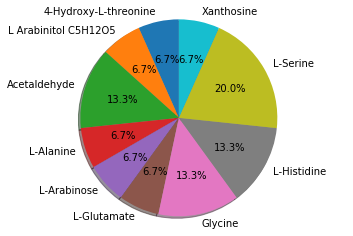

In [67]:
import pandas as pd
import numpy as np
df = pd.read_csv('minimal_compounds_ex.txt',sep='\t')


import matplotlib.pyplot as plt
sizes = df['count']
labels= df['compound']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

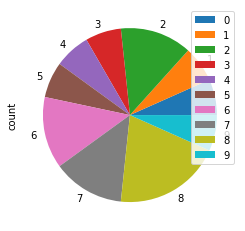

In [65]:
#counts = df.groupby('compound')['compound'].count()
df.plot.pie(y='count')

In [54]:
!python C:\Users\daven\AppData\Local\Programs\Python\Python36\Scripts\smetana --flavor cobra  --molweight -g -o "C:\Users\daven\Documents\bioinformatika\metabolic modeling\project\smetana_simple" "C:\Users\daven\Documents\bioinformatika\metabolic modeling\project\*.xml"

In [55]:
dfs = pd.read_csv('smetana_simple_global.tsv',sep='\t')
print(dfs)

  community    medium  size  mip       mro
0       all  complete     4    6  0.713615


In [72]:
df_full = pd.read_csv('smetana_out_detailed.tsv',sep='\t')
mus = df_full.groupby(['receiver','compound'])['mus'].sum()

print(mus)

receiver                  compound   
Rothia_mucilaginosa       M_ade_e        0.020000
                          M_ala__D_e     0.030000
                          M_fol_e        0.020000
                          M_fum_e        0.010000
                          M_glc__D_e     0.070000
                          M_gly_e        0.210000
                          M_glyc_e       0.040000
                          M_h2o_e        0.050000
                          M_h_e          0.010000
                          M_his__L_e     1.000000
                          M_ile__L_e     0.010000
                          M_lac__L_e     0.140000
                          M_malt_e       0.040000
                          M_malttr_e     0.220000
                          M_pi_e         0.400000
                          M_ser__D_e     0.730000
                          M_ser__L_e     0.120000
                          M_thr__L_e     0.060000
Streptococcus_cristatus   M_abt__L_e     0.350000
            

In [ ]:
# run the abiotic preturbations for some compounds

python C:\Users\daven\AppData\Local\Programs\Python\Python36\Scripts\smetana 
    -a "C:\Users\daven\Documents\bioinformatika\metabolic modeling\project\substrates.txt" 
    -v 
    -n 0 
    --exclude "C:\Users\daven\Documents\bioinformatika\metabolic modeling\project\inorganic.txt" 
    --flavor cobra  
    --molweight 
    -o "C:\Users\daven\Documents\bioinformatika\metabolic modeling\project\smetana_simple_abiotic" 
    "C:\Users\daven\Documents\bioinformatika\metabolic modeling\project\*.xml"
    

In [4]:
# visualize the result in 

import pandas as pd
import numpy as np
df = pd.read_csv('smetana_simple_abiotic_detailed.tsv',sep='\t')
df = df[df['smetana'] > 0.1]

df.to_csv("smetana_simple_abiotic_detailed_filtered.tsv",sep="\t", index=False)

In [40]:
from framed import load_cbmodel, pFBA
from framed.experimental import medium
from framed import Environment
from framed import Community
from smetana import minimal_environment
#TODO: escher analyze the pathways
df_all = df
#df_all je dataframe - vystup ze smetany

models_inCom = []
for f in ['Rothia_mucilaginosa','Streptococcus_cristatus','Streptococcus_salivarius','Veillonella_parvula']:
    models_inCom.append(load_cbmodel(r'C:\Users\daven\Documents\bioinformatika\metabolic modeling\project\\'+f+'.xml', flavor='cobra'))

print(models_inCom)

df_grouped = df_all#.groupby(['community', 'medium'])

substrate_df = []



#count minimal media for community
print('Calculating minimal medium')
#work = name[0].replace('s_s', 's-s')
#to_use = [model_idents.index(ident) for ident in work.split('_')]
#models_inCom = [model_objects[i] for i in range(len(model_objects)) if i in to_use]
    
new_community = Community("", models_inCom, copy_models=False)
env = minimal_environment(new_community, verbose=True, min_mol_weight=True)
minimal_media = env.get_compounds()
    
print('Getting perturbation')
    
perturbation = ['thymd']
#print(perturbation)
minimal_media.extend(perturbation)
    
to_use = [0,1,2,3]
    
names = ['Rothia_mucilaginosa','Streptococcus_cristatus','Streptococcus_salivarius','Veillonella_parvula']
#for every organism calculate growth 
for i in to_use:
    #determine received compounds from other bacteria, add it to minimal media
    m_name = names[i]
    print('Organism: %s' %m_name)
    #print(m_name)
    rec = group[group['receiver'] == m_name]['compound'].tolist()
    #print('receiveing', rec)
    used_media = list(set(minimal_media + rec))
    #print(used_media)
    #used_media_2 = ['_'.join(med.split('_')[1:med.split('_').index('e')]) for med in used_media]
    #print('used media', used_media)
    #for j in zip(used_media, used_media_2):
    #    print(j)
    #growth
        
    m_model = models_inCom[i]
    print('Applying medium')
    Environment.from_compounds(used_media_2).apply(m_model)
    #print('Running pFBA')
    #solution = pFBA(m_model)
    #print( 'growth rate', solution.values[m_model.biomass_reaction] )
    #print( solution )
        
    other_reactions = set(m_model.get_exchange_reactions()) - set(env)
    new_reactions, sol = medium.minimal_medium(m_model, exchange_reactions=other_reactions, min_mass_weight=True)
    for r_id in new_reactions:
        m_model.set_lower_bound(r_id, -10)
    
    print('Running pFBA')
    solution = pFBA(m_model)
    print( 'growth rate', solution.values[m_model.biomass_reaction] )
    
    substrate_df.append( (name[0], name[1], m_name, solution.values[m_model.biomass_reaction]) )
    #comunity, media, organism, growth
    print('______________________________________________________')
    print()
df_growth = pd.DataFrame(substrate_df, columns=['community','medium','organism','growth'])

[<framed.model.cbmodel.CBModel object at 0x000001E53E774D68>, <framed.model.cbmodel.CBModel object at 0x000001E53ED7C240>, <framed.model.cbmodel.CBModel object at 0x000001E541347358>, <framed.model.cbmodel.CBModel object at 0x000001E541CDFF98>]
Calculating minimal medium
Getting perturbation
Organism: Rothia_mucilaginosa
Applying medium


c:\users\daven\appdata\local\programs\python\python36\lib\site-packages\framed\experimental\medium.py:48: UserWarning: Coupounds with multiple formulas (using first): M_nmn_e,M_tsul_e,M_so3_e,M_pi_e,M_fol_e,M_quin_e,M_so4_e,M_meoh_e,M_nh4_e,M_taur_e,M_urea_e,M_h2s_e,M_h2co3_e,M_pheme_e,M_gua_e
  warn(message)


Running pFBA
growth rate 0.7420541531184115
______________________________________________________

Organism: Streptococcus_cristatus
Applying medium


c:\users\daven\appdata\local\programs\python\python36\lib\site-packages\framed\experimental\medium.py:48: UserWarning: Coupounds with multiple formulas (using first): M_nmn_e,M_ribflv_e,M_tsul_e,M_pi_e,M_citr__L_e,M_so4_e,M_meoh_e,M_for_e,M_nh4_e,M_h2s_e,M_pheme_e,M_gua_e,M_pnto__R_e
  warn(message)


Running pFBA
growth rate 0.2456937774321226
______________________________________________________

Organism: Streptococcus_salivarius
Applying medium


c:\users\daven\appdata\local\programs\python\python36\lib\site-packages\framed\experimental\medium.py:48: UserWarning: Coupounds with multiple formulas (using first): M_nmn_e,M_ribflv_e,M_tsul_e,M_pi_e,M_hco3_e,M_fol_e,M_so4_e,M_gthrd_e,M_meoh_e,M_for_e,M_nh4_e,M_urea_e,M_h2s_e,M_gthox_e,M_pheme_e,M_gua_e,M_cyst__L_e,M_pnto__R_e,M_alltn_e
  warn(message)


Running pFBA
growth rate 0.5109913022782884
______________________________________________________

Organism: Veillonella_parvula
Applying medium


c:\users\daven\appdata\local\programs\python\python36\lib\site-packages\framed\experimental\medium.py:48: UserWarning: Coupounds with multiple formulas (using first): M_nmn_e,M_tsul_e,M_so3_e,M_pi_e,M_so4_e,M_gthrd_e,M_meoh_e,M_for_e,M_nh4_e,M_taur_e,M_urea_e,M_h2s_e,M_gthox_e,M_pheme_e,M_gua_e,M_rnam_e
  warn(message)


Running pFBA
growth rate 0.7218213544372588
______________________________________________________



In [28]:
print(df_grouped)

In [76]:
import escher
escher.list_available_maps()

[{'organism': 'Saccharomyces cerevisiae',
  'map_name': 'iMM904.Central carbon metabolism'},
 {'organism': 'Homo sapiens',
  'map_name': 'RECON1.Inositol retinol metabolism'},
 {'organism': 'Homo sapiens', 'map_name': 'RECON1.Glycolysis TCA PPP'},
 {'organism': 'Homo sapiens', 'map_name': 'RECON1.Tryptophan metabolism'},
 {'organism': 'Homo sapiens', 'map_name': 'RECON1.Carbohydrate metabolism'},
 {'organism': 'Homo sapiens',
  'map_name': 'RECON1.Amino acid metabolism (partial)'},
 {'organism': 'Escherichia coli', 'map_name': 'iJO1366.Nucleotide metabolism'},
 {'organism': 'Escherichia coli',
  'map_name': 'iJO1366.Fatty acid biosynthesis (saturated)'},
 {'organism': 'Escherichia coli',
  'map_name': 'iJO1366.Nucleotide and histidine biosynthesis'},
 {'organism': 'Escherichia coli', 'map_name': 'e_coli_core.Core metabolism'},
 {'organism': 'Escherichia coli', 'map_name': 'iJO1366.Central metabolism'},
 {'organism': 'Escherichia coli',
  'map_name': 'iJO1366.Fatty acid beta-oxidation'}

In [75]:
from framed.experimental.visualization.escher_maps import build_escher_map
org_fluxes = new_community.split_fluxes(solution.values)

#build_escher_map(org_fluxes['Rothia_mucilaginosa'], 'e_coli_core.Core metabolism')
#build_escher_map(org_fluxes['Streptococcus_cristatus'], 'e_coli_core.Core metabolism')
#build_escher_map(org_fluxes['Streptococcus_salivarius'], 'e_coli_core.Core metabolism')
build_escher_map(org_fluxes['Veillonella_parvula'], 'v_parvula_core.Core metabolism')

Exception: Could not find the map v_parvula_core.Core metabolism on the server